In [ ]:
!pip install Ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.4 MB/s eta 0:00:00


In [2]:
#Flash Attention CUDA Megakernel Implementation
#Demonstrates memory-efficient attention via tiling and online softmax
import os
import math
import torch
from torch.nn import functional as F
from torch.utils.cpp_extension import load_inline

#CUDA kernel implementing Flash Attention algorithm
#Uses shared memory tiling to minimize HBM accesses
cuda_src = '''
__global__
void forward_kernel(const float* Q, const float* K, const float* V,
                    const int N, const int d,
                    const int Tc, const int Tr,
                    const int Bc, const int Br,
                    const float softmax_scale,
                    float* l, float *m, float* O){
    //Thread and block indices
    int tx = threadIdx.x;
    int bx = blockIdx.x;  //batch index
    int by = blockIdx.y;  //head index

    //Compute offsets for this batch and head
    //Each block processes one (batch, head) combination
    int qkv_offset = (bx * gridDim.y * N * d) + (by * N * d);
    int lm_offset = (bx * gridDim.y * N) + (by * N);

    //Allocate shared memory (SRAM) for Q, K, V tiles and attention scores
    //SRAM usage: 3 tiles (Qi, Kj, Vj) + score matrix S
    extern __shared__ float sram[];
    int tile_size = Bc * d;
    float* Qi = sram;                    //Query tile
    float* Kj = &sram[tile_size];        //Key tile
    float* Vj = &sram[tile_size * 2];    //Value tile
    float* S = &sram[tile_size * 3];     //Attention scores (Bc x Br)

    //Outer loop: iterate over key/value tiles (columns)
    for(int j = 0; j < Tc; j++){
        //Load Kj and Vj tiles from HBM to SRAM
        //Each thread loads one row of the tile
        for(int x = 0; x < d; x++){
            Kj[(tx * d) + x] = K[qkv_offset + (tile_size * j) + (tx * d) + x];
            Vj[(tx * d) + x] = V[qkv_offset + (tile_size * j) + (tx * d) + x];
        }
        __syncthreads();  //Ensure all threads have loaded K, V before proceeding

        //Inner loop: iterate over query tiles (rows)
        for(int i = 0; i < Tr; i++){
            //Load Qi tile from HBM to SRAM
            for(int x = 0; x < d; x++){
                Qi[(tx * d) + x] = Q[qkv_offset + (tile_size * i) + (tx * d) + x];
            }

            //Load previous max and sum for this row (online softmax)
            float row_m_prev = m[lm_offset + (Br * i) + tx];
            float row_l_prev = l[lm_offset + (Br * i) + tx];

            //Compute S = QK^T and track row-wise maximum (for numerical stability)
            float row_m = -INFINITY;
            for(int y = 0; y < Bc; y++){
                float sum = 0;
                //Dot product between query and key vectors
                for(int x = 0; x < d; x++){
                    sum += Qi[(tx * d) + x] * Kj[(y * d) + x];
                }
                sum *= softmax_scale;  //Scale by 1/sqrt(d)
                S[(Bc * tx) + y] = sum;

                //Track maximum for stable softmax computation
                if(sum > row_m)
                    row_m = sum;
            }

            //Compute P = exp(S - row_m) and row sum (online softmax numerator)
            float row_l = 0;
            for(int y = 0; y < Bc; y++){
                S[(Bc * tx) + y] = __expf(S[(Bc * tx) + y] - row_m);
                row_l += S[(Bc * tx) + y];
            }

            //Update running statistics for online softmax across tiles
            float row_m_new = max(row_m_prev, row_m);
            float row_l_new = (__expf(row_m_prev - row_m_new) * row_l_prev) +
                             (__expf(row_m - row_m_new) * row_l);

            //Compute output: O = (corrected previous O + new P*V) / new_sum
            //This implements the online softmax rescaling
            for(int x = 0; x < d; x++){
                float pv = 0;  //Compute (attention scores) * V
                for(int y = 0; y < Bc; y++){
                    pv += S[(Bc * tx) + y] * Vj[(y * d) + x];
                }
                //Rescale previous output and add new contribution
                O[qkv_offset + (tile_size * i) + (tx * d) + x] =
                    (1 / row_l_new) *
                    ((row_l_prev * __expf(row_m_prev - row_m_new) *
                      O[qkv_offset + (tile_size * i) + (tx * d) + x]) +
                     (__expf(row_m - row_m_new) * pv));
            }

            //Update running max and sum for next iteration
            m[lm_offset + (Br * i) + tx] = row_m_new;
            l[lm_offset + (Br * i) + tx] = row_l_new;
        }
        __syncthreads();  //Sync before loading next K, V tiles
    }
}

torch::Tensor forward(torch::Tensor Q, torch::Tensor K, torch::Tensor V){
    //Tile sizes (fixed for simplicity; could be tuned dynamically)
    const int Bc = 32;  //Column tile size
    const int Br = 32;  //Row tile size

    //Extract tensor dimensions
    const int B = Q.size(0);   //batch size
    const int nh = Q.size(1);  //number of heads
    const int N = Q.size(2);   //sequence length
    const int d = Q.size(3);   //head dimension

    //Calculate number of tiles needed
    const int Tc = ceil((float)N / Bc);
    const int Tr = ceil((float)N / Br);
    const float softmax_scale = 1.0 / sqrt(d);

    //Initialize output and running statistics in HBM
    auto O = torch::zeros_like(Q);
    auto l = torch::zeros({B, nh, N});      //Running sum for softmax
    auto m = torch::full({B, nh, N}, -INFINITY);  //Running max for softmax
    torch::Device device(torch::kCUDA);
    l = l.to(device);
    m = m.to(device);

    //Calculate shared memory requirement
    //3 tiles (Q, K, V) + attention score matrix
    const int sram_size = (3 * Bc * d * sizeof(float)) + (Bc * Br * sizeof(float));
    int max_sram_size;
    cudaDeviceGetAttribute(&max_sram_size, cudaDevAttrMaxSharedMemoryPerBlock, 0);
    printf("Max shared memory: %d, requested shared memory: %d \\n",
           max_sram_size, sram_size);

    //Configure kernel launch parameters
    dim3 grid_dim(B, nh);   //One block per (batch, head) pair
    dim3 block_dim(Bc);     //Bc threads per block

    //Launch Flash Attention kernel
    forward_kernel<<<grid_dim, block_dim, sram_size>>>(
        Q.data_ptr<float>(), K.data_ptr<float>(), V.data_ptr<float>(),
        N, d, Tc, Tr, Bc, Br, softmax_scale,
        l.data_ptr<float>(), m.data_ptr<float>(), O.data_ptr<float>()
    );

    return O;
}
'''

cpp_src = 'torch::Tensor forward(torch::Tensor Q, torch::Tensor K, torch::Tensor V);'

#Build CUDA extension
build_dir = 'cuda'
if not os.path.exists(build_dir):
    os.mkdir(build_dir)

print("Compiling Flash Attention CUDA kernel...")
minimal_attn = load_inline(
    name='minimal_attn',
    cpp_sources=cpp_src,
    cuda_sources=cuda_src,
    functions=['forward'],
    with_cuda=True,
    extra_cuda_cflags=['-O2'],
    build_directory=f'./{build_dir}'
)
print("Compilation complete.\n")

#Test configuration
batch_size = 32
n_head = 12
seq_len = 64
head_embd = 32

#Initialize random input tensors on GPU
q = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()
k = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()
v = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()

#Baseline: Standard attention implementation (unfused operators)
def manual_attn(q, k, v):
    att = (q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1))))
    att = F.softmax(att, dim=-1)
    y = att @ v
    return y

#Profile baseline attention
print('=== Profiling Baseline Attention (Unfused) ===')
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    manual_result = manual_attn(q, k, v)
print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))

#Profile Flash Attention megakernel
print('=== Profiling Flash Attention Megakernel ===')
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    minimal_result = minimal_attn.forward(q, k, v)
print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))

#Verify correctness (allow small numerical difference due to FP arithmetic)
print('Attention values sanity check:',
      torch.allclose(minimal_result, manual_result, rtol=0, atol=1e-02))

#Tensor Core variant: Uses FP16 mixed precision
print('\n=== Profiling Baseline Attention with Tensor Cores (FP16) ===')

#Convert to half precision for Tensor Core usage
q_fp16 = q.clone().half()
k_fp16 = k.clone().half()
v_fp16 = v.clone().half()

def manual_attn_fp16(q, k, v):
    #Autocast enables mixed-precision: FP16 matmuls on Tensor Cores
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        att = (q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1))))
        att = F.softmax(att, dim=-1)
        y = att @ v
    return y

#Profile Tensor Core variant
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    manual_fp16_result = manual_attn_fp16(q_fp16, k_fp16, v_fp16)
print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))

#Verify Tensor Core variant (increased tolerance for FP16)
print('Attention values sanity check (FP16):',
      torch.allclose(minimal_result, manual_fp16_result.float(), rtol=0, atol=1e-01))

Compiling Flash Attention CUDA kernel...
Compilation complete.

=== Profiling Baseline Attention (Unfused) ===


/tmp/ipython-input-3072022930.py:196: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:


-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     aten::matmul         3.35%       6.724ms        59.84%     120.196ms      60.098ms       6.665ms         3.32%     120.279ms      60.139ms             2  
                                        aten::bmm        28.08%      56.410ms        54.37%     109.215ms      54.608ms     109.385ms        54.44%     109.385ms      54.693ms             2  
                                    ate

/tmp/ipython-input-3072022930.py:202: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:


Attention values sanity check: True

=== Profiling Baseline Attention with Tensor Cores (FP16) ===
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     aten::matmul         0.24%     296.260us       198.92%     242.379ms      60.595ms     235.000us         0.19%     242.511ms      60.628ms             4  
                                        aten::bmm        56.47%      68.807ms        99.07%     120.712ms      60.356ms     120.877m

/tmp/ipython-input-3072022930.py:227: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:



=== Benchmarking FP32 vs FP16 Across Sequence Lengths ===
Testing seq_len=64... FP32: 0.20ms, FP16: 0.19ms, Speedup: 1.04x
Testing seq_len=128... FP32: 0.65ms, FP16: 0.42ms, Speedup: 1.55x
Testing seq_len=256... FP32: 2.31ms, FP16: 1.39ms, Speedup: 1.66x
Testing seq_len=512... FP32: 9.00ms, FP16: 5.29ms, Speedup: 1.70x
Testing seq_len=1024... FP32: 30.31ms, FP16: 18.98ms, Speedup: 1.60x
Testing seq_len=2048... FP32: 126.51ms, FP16: 92.06ms, Speedup: 1.37x

Plot saved as 'attention_performance.png'


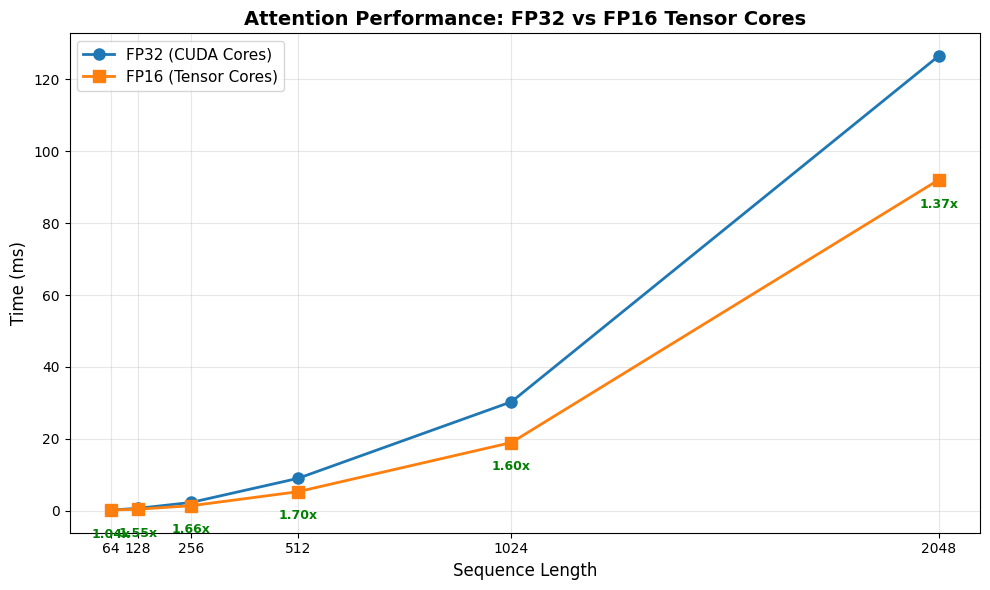

In [5]:
#Benchmark across different sequence lengths to show Tensor Core scaling
print("\n=== Benchmarking FP32 vs FP16 Across Sequence Lengths ===")
import matplotlib.pyplot as plt
import time

#Test parameters
batch_size_bench = 16
n_head_bench = 12
head_embd_bench = 64
seq_lengths = [64, 128, 256, 512, 1024, 2048]
num_warmup = 3
num_iters = 10

fp32_times = []
fp16_times = []

for seq_len in seq_lengths:
    print(f"Testing seq_len={seq_len}...", end=" ")

    #Generate test data
    q_test = torch.randn(batch_size_bench, n_head_bench, seq_len, head_embd_bench).cuda()
    k_test = torch.randn(batch_size_bench, n_head_bench, seq_len, head_embd_bench).cuda()
    v_test = torch.randn(batch_size_bench, n_head_bench, seq_len, head_embd_bench).cuda()

    #FP32 benchmark
    #Warmup
    for _ in range(num_warmup):
        _ = manual_attn(q_test, k_test, v_test)
    torch.cuda.synchronize()

    #Timed runs
    start = time.time()
    for _ in range(num_iters):
        _ = manual_attn(q_test, k_test, v_test)
    torch.cuda.synchronize()
    fp32_time = (time.time() - start) / num_iters * 1000  #Convert to ms
    fp32_times.append(fp32_time)

    #FP16 benchmark
    q_test_fp16 = q_test.half()
    k_test_fp16 = k_test.half()
    v_test_fp16 = v_test.half()

    #Warmup
    for _ in range(num_warmup):
        _ = manual_attn_fp16(q_test_fp16, k_test_fp16, v_test_fp16)
    torch.cuda.synchronize()

    #Timed runs
    start = time.time()
    for _ in range(num_iters):
        _ = manual_attn_fp16(q_test_fp16, k_test_fp16, v_test_fp16)
    torch.cuda.synchronize()
    fp16_time = (time.time() - start) / num_iters * 1000  #Convert to ms
    fp16_times.append(fp16_time)

    print(f"FP32: {fp32_time:.2f}ms, FP16: {fp16_time:.2f}ms, Speedup: {fp32_time/fp16_time:.2f}x")

#Create performance plot
plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, fp32_times, marker='o', linewidth=2, markersize=8, label='FP32 (CUDA Cores)')
plt.plot(seq_lengths, fp16_times, marker='s', linewidth=2, markersize=8, label='FP16 (Tensor Cores)')

plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
plt.title('Attention Performance: FP32 vs FP16 Tensor Cores', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(seq_lengths)

#Add speedup annotations
for i, seq_len in enumerate(seq_lengths):
    speedup = fp32_times[i] / fp16_times[i]
    plt.annotate(f'{speedup:.2f}x',
                xy=(seq_len, fp16_times[i]),
                xytext=(0, -20),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                color='green',
                fontweight='bold')

plt.tight_layout()
plt.savefig('attention_performance.png', dpi=150, bbox_inches='tight')
print("\nPlot saved as 'attention_performance.png'")
plt.show()